In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
#reference medium.com/@rmache/big-data-with-spark-in-google-colab-7c046e24b3

In [3]:
# Install spark-related dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

!pip install -q findspark
!pip install pyspark
# Set up required environment variables

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

     |████████████████████████████████| 217.8MB 63kB/s 
     |████████████████████████████████| 204kB 54.1MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=ebfaf7fd2615bc287f7a8cfd5412e0a295d613e9bee91f5969897ea8a3b69c8a
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [0]:
# Tools we need to connect to the Spark server, load our data,
# clean it and prepare it
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, OneHotEncoderEstimator, StringIndexer, VectorAssembler, VectorIndexer, Imputer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.sql.functions import isnan, when, count, col

# Set up constants
mpdata = "/content/gdrive/My Drive/Colab/mp_data_24hr.csv" 
APP_NAME = "mp_data_6hr"
SPARK_URL = "local[*]"
RANDOM_SEED = 42
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 10
RF_MAX_DEPTH = 10
RF_NUM_BINS = 32

In [0]:
# Connect to the Spark server

spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()

# Load datasets

df = spark.read.options(header="true",inferschema = "true").csv(mpdata)

In [8]:
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")

The shape is 49741 rows by 131 columns.


In [11]:
# make sure no null values
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c)for c in df.columns]).toPandas().to_dict(orient='records')
print(f"We have {sum(null_counts[0].values()):d} null values in this dataset.")

We have 2544355 null values in this dataset.


Drop unnecessary columns.

In [0]:
columns_to_drop = ['subject_id', 'hadm_id', 'icustay_id', 'dbsource', 'expire_flag', 'deathtime_hours', 'hosp_deathtime_hours']
df = df.drop(*columns_to_drop)
df = df.withColumnRenamed("hospital_expire_flag", "label")

In [13]:
df.show(2)

+-----+-------+------+---------+--------------+-----------+--------------+----------+-----------+-----------+-------------+----------+---------+------------------+-------------+---------+----------+----------+------------+---------+--------+-----------+-------------+---------+----------+----------+------------+---------+--------+-----------+--------+-------------+--------------+------------+------------------+-------+------------+-------------+-----------+-----------------+-------+------------+-------------+-----------+-----------------+---------------+----------------------+------------------+--------+------------------+-----------------+------------------+------------------+------------------+------------+----------+----------------+--------------+------------------+---------------+------------------+------------------+---------------+-----------------+-------------+-----------------+--------+--------+-----------+--------+-----------------+--------------+---------------------+-------

In [14]:
# df.printSchema()
from collections import defaultdict
data_types = defaultdict(list)
for field in df.schema.fields:
    data_types[str(field.dataType)].append(field.name)
for key in data_types.keys():
    print(key, len(data_types[key]))

IntegerType 20
DoubleType 101
StringType 3


Category Indexing, One-Hot Encoding, Imputer, and VectorAssembler - a feature transformer that merges multiple columns into a vector column.

The code below indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. VectorAssembler combines all the feature columns into a single vector column.

In [0]:
stages = []

# categorical features
categoricalColumns = ['ethnicity','gender','admission_type']

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index').setHandleInvalid("keep") # keep unseen labels
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

# numerical features    
numericCols = ['age', 'icustay_num',
               'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
               'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
               'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
               'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
               'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
               'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
               'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
               'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
               'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
               'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
               'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
               'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
               'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
               'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
               'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
               'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
               'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
               'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
               'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
               'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
               'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
               'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
               'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
               'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
               'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
               'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
               'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
               'urineoutput']

imputer = Imputer(strategy='median', inputCols=numericCols, outputCols=['imputed_' + col for col in numericCols])
stages += [imputer]

# assemble
assemblerInputs = [c + "classVec" for c in categoricalColumns] + ['imputed_' + col for col in numericCols]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [16]:
# categorical columns fill na
df = df.fillna('missing', subset=categoricalColumns)
# cast integer columns to double datatype for the imputer
for col in numericCols:
    if col in data_types['IntegerType']:
        df = df.withColumn(col, df[col].cast('double'))
# check
data_types = defaultdict(list)
for field in df.schema.fields:
    data_types[str(field.dataType)].append(field.name)
for key in data_types.keys():
    print(key, len(data_types[key]))

IntegerType 1
DoubleType 120
StringType 3


Randomly aplit the dataset to 80% training and 20% testing.

In [0]:
train, test = df.randomSplit([0.8, 0.2], seed = 0)

Use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [0]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)

In [19]:
selectedCols = ['label', 'features']
train = train.select(selectedCols)
test = test.select(selectedCols)
train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



### Train the Random Forest Model

Visualize the prediction labels

In [20]:
# Train the RandomForest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=RF_NUM_TREES)

rfModel = rf.fit(train)
predictions = rfModel.transform(test)
#predicted labels
predictions.select('rawPrediction', 'prediction', 'probability').show(5)

+--------------------+----------+--------------------+
|       rawPrediction|prediction|         probability|
+--------------------+----------+--------------------+
|[9.33257360881814...|       0.0|[0.93325736088181...|
|[9.19607274599654...|       0.0|[0.91960727459965...|
|[8.94228345775812...|       0.0|[0.89422834577581...|
|[8.63034227282166...|       0.0|[0.86303422728216...|
|[9.26670793274589...|       0.0|[0.92667079327458...|
+--------------------+----------+--------------------+
only showing top 5 rows



In [21]:
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(auc))

Test Area Under ROC: 0.7775797450400299


### Tune the parameter and achieve better auc score

In [22]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [5, 10, 20])
             .addGrid(rf.maxDepth, [5, 10, 20])
             .addGrid(rf.maxBins, [10, 32])
             .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8452904676971527

The AUC-ROC score for the testing dataset is 0.81

In [23]:
bestModel = cvModel.bestModel
print('Best Param (Number of Trees): ', bestModel._java_obj.getNumTrees())
print('Best Param (Max Depth): ', bestModel._java_obj.getMaxDepth())
print('Best Param (Max Bins): ', bestModel._java_obj.getMaxBins())

Best Param (Number of Trees):  20
Best Param (Max Depth):  20
Best Param (Max Bins):  32


Alternative way to draw AUC-ROC curve

In [0]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

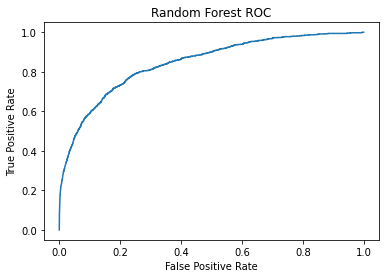

In [25]:
import matplotlib.pyplot as plt

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Random Forest ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

**Draw the AUC-ROC curve for the best random forest model**



In [0]:
preds = predictions.select('label','probability')\
    .rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))\
    .collect()
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_score, y_true = zip(*preds)
fpr, tpr, _ = roc_curve(y_true, y_score, pos_label = 1)
roc_auc = roc_auc_score(y_true, y_score)

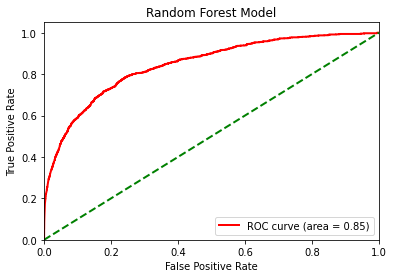

In [27]:
lw = 2
plt.plot(fpr, tpr, color='red', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='green', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model')
plt.legend(loc="lower right")